<a href="https://colab.research.google.com/github/metard/ISIC_ImageProcessing_final/blob/main/Overview_of_Colaboratory_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SAYISAL GÖRÜNTÜ İŞLEME DERSİ FİNAL ÖDEVİ
## Projenin Amacı ve Kapsamı

## Arasınavda yapılan RGB ve Grayscale görüntü işleme ve iyileştirme adımlarını “segmentasyon hattına” dönüştürerek her görüntü için tek bir ROI (lezyon bölgesi) elde etmek ve bu ROI üzerinden öznitelik (feature) seti üretmek.

## Çalışma Ortamı ve Veri hazırlığı (Setup)

In [14]:
# ==========================================================
# SETUP CELL – DATA DOWNLOAD & DataFrame Creation
# ==========================================================

import os
import zipfile
import pandas as pd # pandas eklendi

# gdown kurulumu
!pip install -q gdown

# Dataset bilgileri
file_id = "1avsAZpYaKvgAg55KBuLPm0z_mFwyUq2-"
url = f"https://drive.google.com/uc?id={file_id}"
zip_path = "isic_data.zip"
extract_path = "/content/data"
DATA_DIR = extract_path # DATA_DIR tanımı eklendi
TRAIN_DIR = DATA_DIR # TRAIN_DIR tanımı eklendi

# Dataset indir
if not os.path.exists(zip_path):
    !gdown {url} -O {zip_path}

# Zip aç
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset indirildi ve hazır.")

# Görüntü yollarını okuma ve DataFrame oluşturma fonksiyonu eklendi
def load_image_paths(directory):
    image_paths = []
    for root, dirs, files in os.walk(directory):
        dirs[:] = [d for d in dirs if d != '__MACOSX'] # __MACOSX dizinlerini hariç tut
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                if '__MACOSX' not in root and '__MACOSX' not in file:
                    image_paths.append(os.path.join(root, file))

    data = []
    for path in image_paths:
        filename = os.path.basename(path)
        image_id = os.path.splitext(filename)[0]
        # Varsayılan etiket 'unknown' olarak ayarlandı, gerçek etiketler için metadata CSV gerekebilir.
        # Şu anki dataset yapısında 'Train/melanoma/ISIC_XXXX.jpg' gibi olduğu için
        # klasör adını etiket olarak alabiliriz.
        label = os.path.basename(os.path.dirname(path))
        data.append({'image_path': path, 'image_id': image_id, 'label': label})

    return pd.DataFrame(data)

# train_df DataFrame'ini oluştur
train_df = load_image_paths(TRAIN_DIR)

print(f"✅ `train_df` DataFrame'i {len(train_df)} görüntü ile oluşturuldu.")


✅ Dataset indirildi ve hazır.
✅ `train_df` DataFrame'i 2357 görüntü ile oluşturuldu.


In [13]:
display(train_df.head())

,image_path,image_id,label
0,/content/data/Train/melanoma/ISIC_0000157.jpg,ISIC_0000157,unknown
1,/content/data/Train/melanoma/ISIC_0000441.jpg,ISIC_0000441,unknown
2,/content/data/Train/melanoma/ISIC_0010690.jpg,ISIC_0010690,unknown
3,/content/data/Train/melanoma/ISIC_0010391.jpg,ISIC_0010391,unknown
4,/content/data/Train/melanoma/ISIC_0010630.jpg,ISIC_0010630,unknown


## ADIM 1 — RGB → GRAYSCALE DÖNÜŞÜMÜ

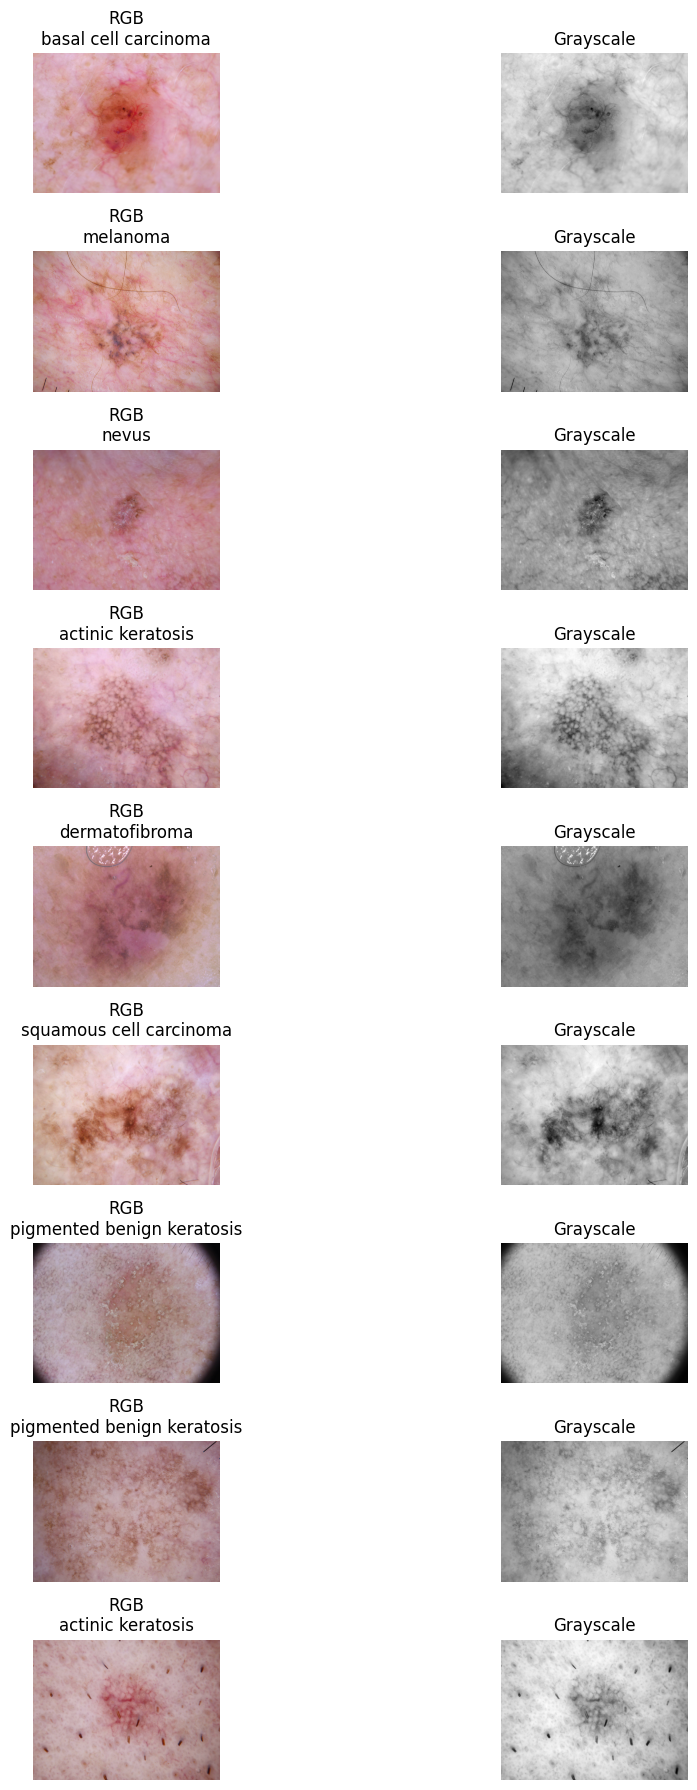

In [18]:
# ==========================================================
# ADIM 1 — RGB → GRAYSCALE DÖNÜŞÜMÜ
# ==========================================================

def read_rgb(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def rgb_to_gray(img_rgb):
    return cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)


# Rastgele 9 görüntü seç
sample_df = train_df.sample(9, random_state=42).reset_index(drop=True)

plt.figure(figsize=(12, 18))

for i, row in sample_df.iterrows():
    rgb = read_rgb(row["image_path"])
    gray = rgb_to_gray(rgb)

    # RGB
    plt.subplot(9, 2, 2*i + 1)
    plt.imshow(rgb)
    plt.title(f"RGB\n{row['label']}")
    plt.axis("off")

    # Grayscale
    plt.subplot(9, 2, 2*i + 2)
    plt.imshow(gray, cmap="gray")
    plt.title("Grayscale")
    plt.axis("off")

plt.tight_layout()
plt.show()

##Yorumlar:
- RGB → Grayscale dönüşümü ile lezyon bölgeleri arka plandan daha belirgin hale gelmiş, segmentasyon hattının temelini oluşturacak uygun bir giriş görüntüsü elde edilmiştir.
- Bu nedenle final ödevi kapsamında geliştirilecek ROI segmentasyon hattının grayscale görüntüler üzerinden ilerlemesi hem metodolojik hem de pratik açıdan doğru bir tercih olmuştur.


## 2. Pre-Processing
### 2.1 Crop (Kırpma)


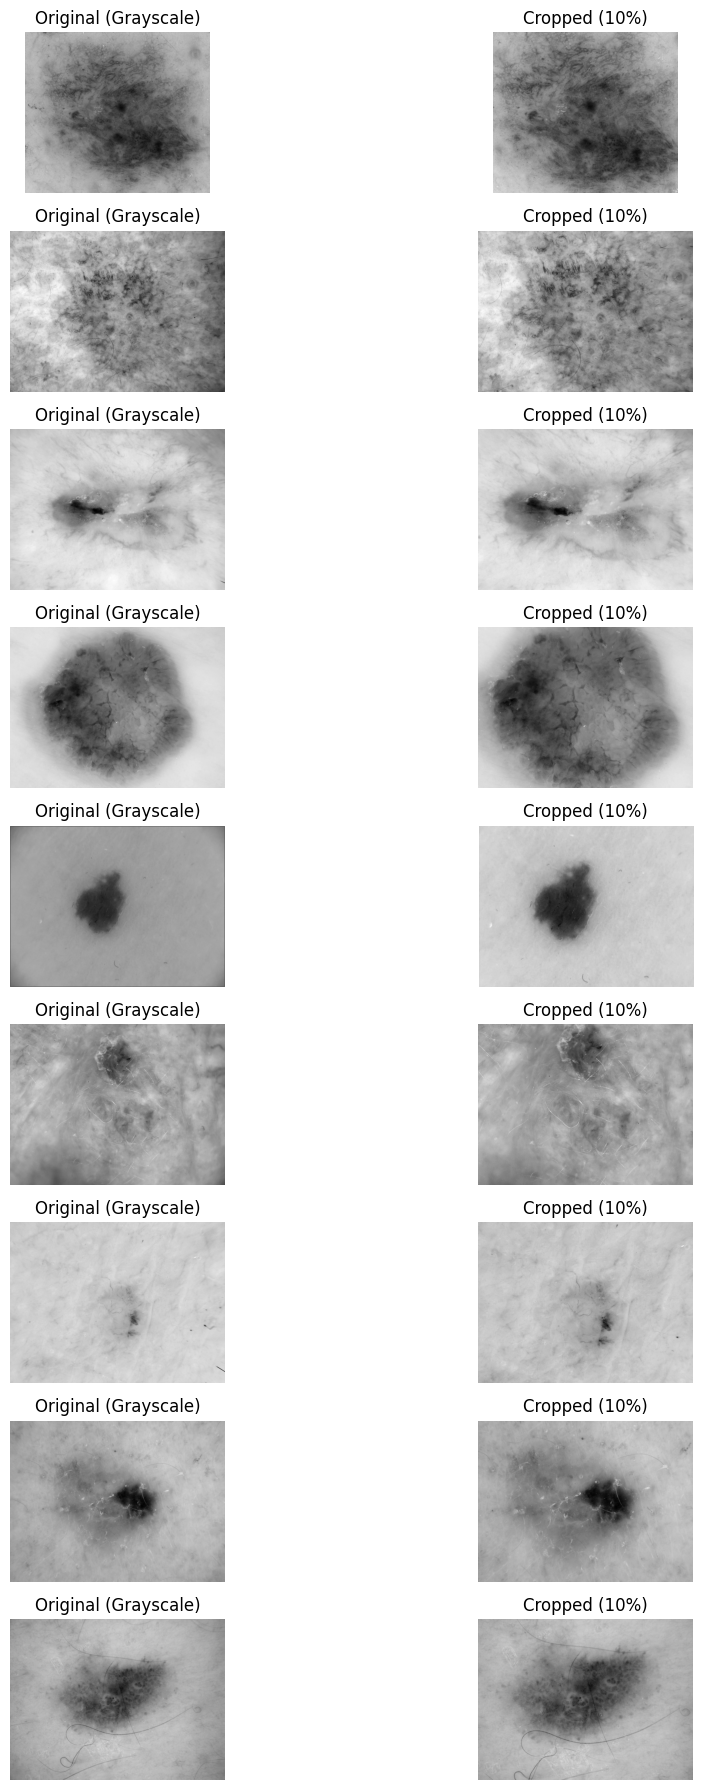

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import glob

# --------------------------------------------------
# Yardımcı fonksiyonlar
# --------------------------------------------------

def read_rgb(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def to_gray(img_rgb):
    return cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

def crop_image(img, crop_ratio=0.10):
    """
    Görüntüyü her kenardan %crop_ratio oranında kırpar.
    """
    h, w = img.shape[:2]
    ch = int(h * crop_ratio)
    cw = int(w * crop_ratio)
    return img[ch:h-ch, cw:w-cw]

# --------------------------------------------------
# 9 RASTGELE GÖRÜNTÜ İÇİN GÖRSELLEŞTİRME
# --------------------------------------------------

all_imgs = glob.glob("/content/data/**/*.*", recursive=True)
all_imgs = [p for p in all_imgs if p.lower().endswith((".jpg", ".png", ".jpeg")) and "__MACOSX" not in p]

samples = random.sample(all_imgs, 9)

plt.figure(figsize=(12, 18))

for i, path in enumerate(samples):
    rgb = read_rgb(path)
    gray = to_gray(rgb)
    cropped = crop_image(gray)

    plt.subplot(9, 2, 2*i + 1)
    plt.imshow(gray, cmap="gray")
    plt.title("Original (Grayscale)")
    plt.axis("off")

    plt.subplot(9, 2, 2*i + 2)
    plt.imshow(cropped, cmap="gray")
    plt.title("Cropped (10%)")
    plt.axis("off")

plt.tight_layout()
plt.show()

## 2.2 Kontrast İyileştirme (Kontrast Germe - Contrast Stretching)

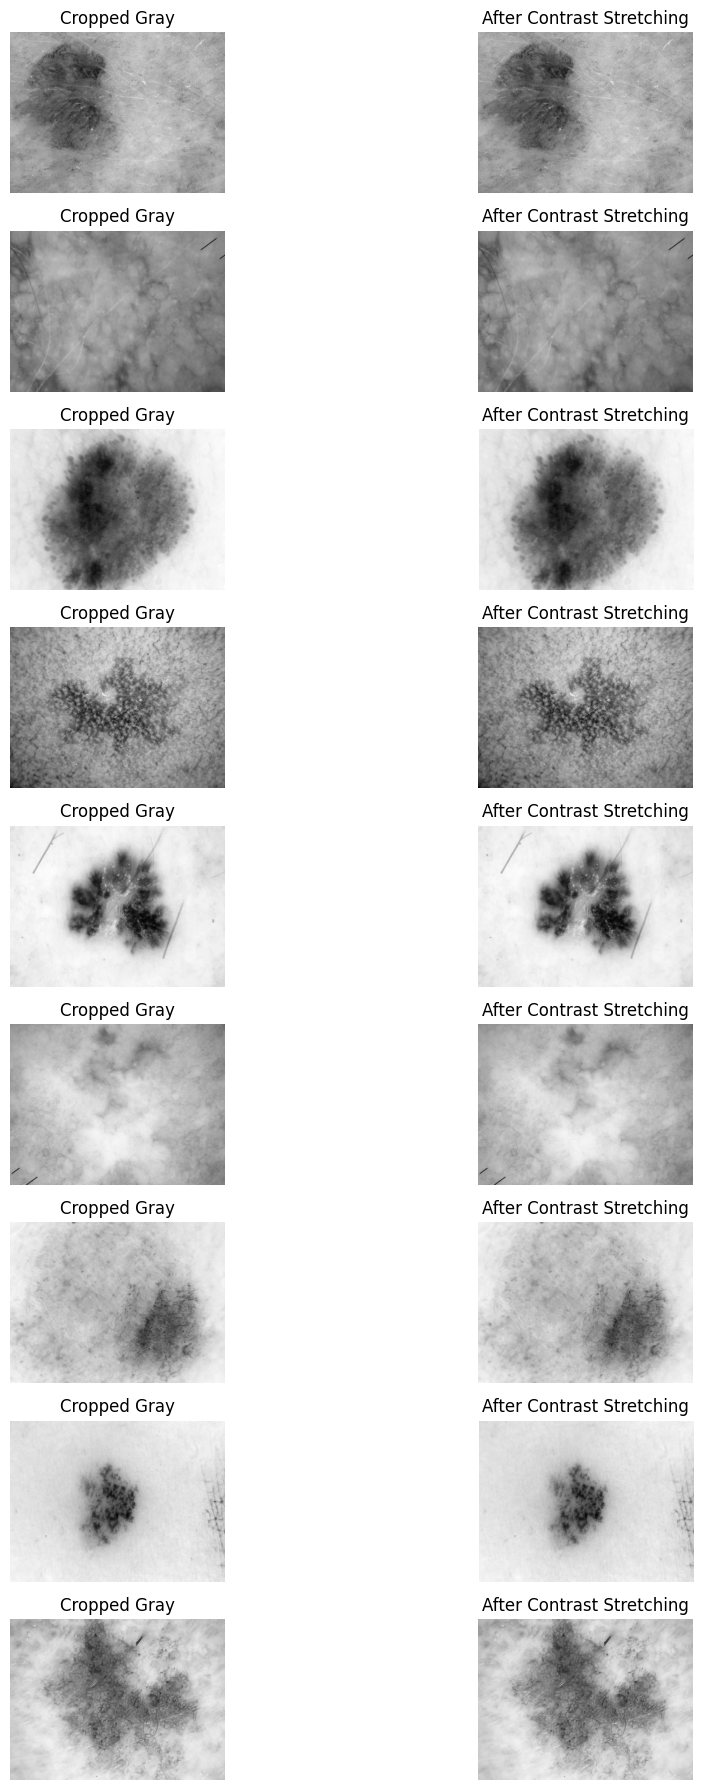

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import glob

# --------------------------------------------------
# Kontrast Germe Fonksiyonu (Grayscale)
# --------------------------------------------------

def contrast_stretch_gray(img):
    p_min, p_max = np.min(img), np.max(img)
    stretched = (img - p_min) * (255 / (p_max - p_min))
    return stretched.astype(np.uint8)

# --------------------------------------------------
# Crop fonksiyonu (önceki adımdan)
# --------------------------------------------------

def crop_image(img, crop_ratio=0.10):
    h, w = img.shape
    ch = int(h * crop_ratio)
    cw = int(w * crop_ratio)
    return img[ch:h-ch, cw:w-cw]

# --------------------------------------------------
# 9 RASTGELE GÖRÜNTÜ
# --------------------------------------------------

all_imgs = glob.glob("/content/data/**/*.*", recursive=True)
all_imgs = [p for p in all_imgs if p.lower().endswith((".jpg", ".png", ".jpeg")) and "__MACOSX" not in p]

samples = random.sample(all_imgs, 9)

plt.figure(figsize=(12, 18))

for i, path in enumerate(samples):
    rgb = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

    cropped = crop_image(gray)
    stretched = contrast_stretch_gray(cropped)

    plt.subplot(9, 2, 2*i + 1)
    plt.imshow(cropped, cmap="gray")
    plt.title("Cropped Gray")
    plt.axis("off")

    plt.subplot(9, 2, 2*i + 2)
    plt.imshow(stretched, cmap="gray")
    plt.title("After Contrast Stretching")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Yorumlar:
(Kontrast Germe Sonrası) görüntüler, soldaki 'Cropped Gray' (Kırpılmış Gri) görüntülere kıyasla daha canlı ve detayları daha belirgin hale gelmiştir. Özellikle lezyon bölgeleri ve çevresindeki doku arasındaki fark daha netleşmiş, bu da segmentasyon gibi sonraki adımlar için daha iyi bir giriş görüntüsü sağlamıştır. Bu işlem, görüntüdeki piksel değerlerinin tüm dinamik aralığa yayılmasını sağlayarak kontrastı artırmıştır.

## 2.3 Gürültü Azaltma / Blurring

In [ ]:
import cv2
import matplotlib.pyplot as plt
import random
import glob
import numpy as np

# --------------------------------------------------
# Önceki adımlardan kullanılan fonksiyonlar
# --------------------------------------------------

def crop_image(img, crop_ratio=0.10):
    h, w = img.shape
    ch = int(h * crop_ratio)
    cw = int(w * crop_ratio)
    return img[ch:h-ch, cw:w-cw]

def contrast_stretch_gray(img):
    p_min, p_max = np.min(img), np.max(img)
    stretched = (img - p_min) * (255 / (p_max - p_min))
    return stretched.astype(np.uint8)

# --------------------------------------------------
# Median Blur
# --------------------------------------------------

def median_blur(img, ksize=5):
    return cv2.medianBlur(img, ksize)

# --------------------------------------------------
# 9 RASTGELE GÖRÜNTÜ İÇİN KARŞILAŞTIRMA
# --------------------------------------------------

all_imgs = glob.glob("/content/data/**/*.*", recursive=True)
all_imgs = [p for p in all_imgs if p.lower().endswith((".jpg", ".png", ".jpeg")) and "__MACOSX" not in p]

samples = random.sample(all_imgs, 9)

plt.figure(figsize=(12, 18))

for i, path in enumerate(samples):
    rgb = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

    cropped = crop_image(gray)
    stretched = contrast_stretch_gray(cropped)
    blurred = median_blur(stretched, ksize=5)

    plt.subplot(9, 2, 2*i + 1)
    plt.imshow(stretched, cmap="gray")
    plt.title("After Contrast Stretching")
    plt.axis("off")

    plt.subplot(9, 2, 2*i + 2)
    plt.imshow(blurred, cmap="gray")
    plt.title("After Median Blur (k=5)")
    plt.axis("off")

plt.tight_layout()
plt.show()